# Predicting Player Ratings for the NBA 2k Video Game

The goal of this project is to predict player Ratings in the NBA 2k Video Game using data from the previous season. For example, the newest 2k Game, 2k23, is for the 2022-2023 NBA season. My hypothesis is that the ratings in 2k23 should be related to player performance from the previous season, the 2021-2022 NBA season. In order to do this, I web scraped real life game data from [Basketball Reference](https://www.basketball-reference.com/) going back to the 2009-2010 season. Since I wanted to include playoff games as well, the data is in 'Total' format, meaning the total number of points, rebounds, etc. across all games played during the season. Player ratings from the 2k video games starting from 2k10 through 2k23 were scraped from [HoopsHype](https://hoopshype.com/nba2k/). A different CSV file was created for both the real-life game data, 'basketball.csv', and the ratings data, 'ratings.csv'. The code for web scraping the data can be found in the 'predict2k.py' file in the GitHub Repository for this project.

### Loading Data and Packages

In [1]:
#Loading in required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
#Loading in the real life game data
bask = pd.read_csv('basketball.csv')
print(bask.shape)

(6963, 24)


Above we can see that the real-life game data contains 6963 observations (players) with 24 variables for each.

In [3]:
#Loading in the player ratings
rats = pd.read_csv('ratings.csv')
labels = rats[rats['2k'] == 2023] 
print(rats.shape)

(6239, 3)


Above we can see that there are ratings for 6,239 players from 2k10 to 2k23. Since the ratings for NBA 2k23, corresponding to data from the 2021-2022 season, just came out, I will save this data as 'labels' to be used for predictions later.

In [4]:
nolabel = bask[bask['2k'] == 2023]
bask = bask[~bask.isin(nolabel)].dropna() #removing the unlabeled data from the original DF
print(nolabel.shape)
print(bask.shape)

(605, 24)
(6358, 24)


There is data for 605 players from the 2021-2022 season that will be used for predictions later. 'Bask' originally had 6963 rows, we can see that 605 rows have been dropped. Next, let’s merge the real-life game data with the player ratings data.


In [5]:
data = pd.merge(left=bask, right=rats, how='inner', on=['Player', '2k'])
print(data.shape)
print('\nRange of game years:')
print(data['2k'].min(), data['2k'].max())

(4840, 25)

Range of game years:
2010.0 2022.0


After merging, we are left with data from 4840 players from 2k10 to 2k22. Now that the data is ready, let's do some Exploratory Data Analysis.

### Exploratory Data Analysis

Since the target variable is 'Rating', let's first take a look at its distribution.

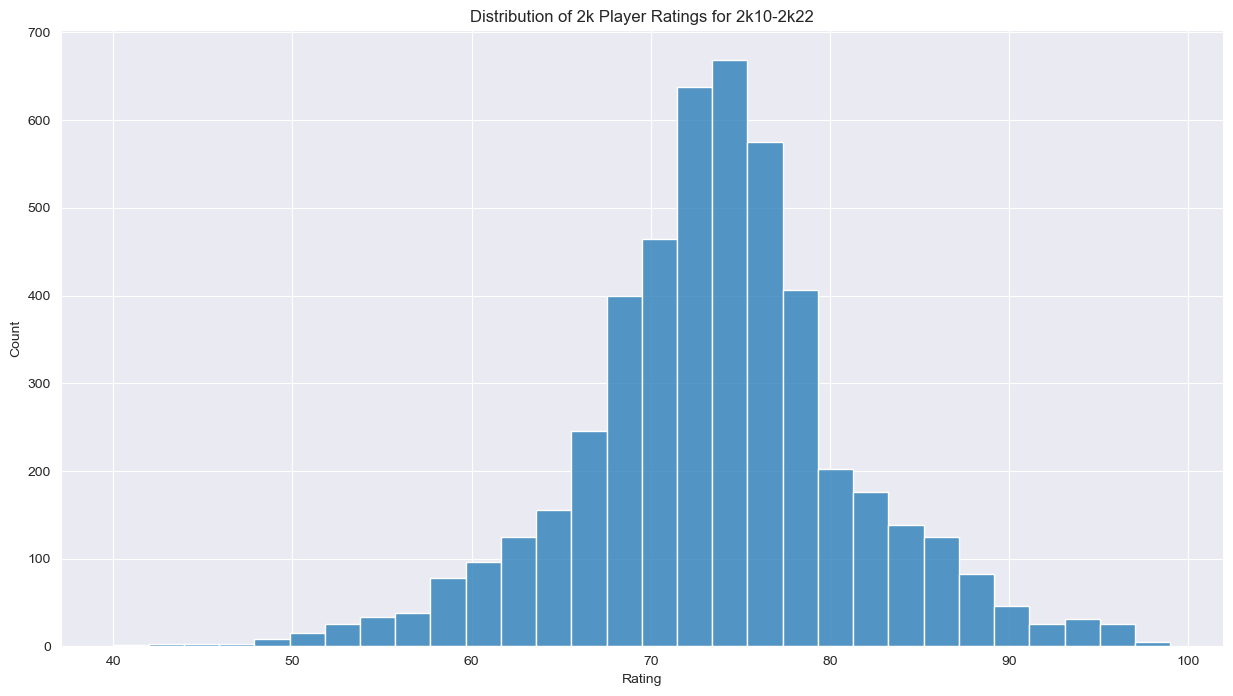

Summary Statistics for "Rating":
count    4840.000000
mean       73.663843
std         7.774967
min        40.000000
25%        69.000000
50%        74.000000
75%        78.000000
max        99.000000
Name: Rating, dtype: float64


In [6]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 8))
sns.histplot(x='Rating', data=data, bins=30)
plt.title('Distribution of 2k Player Ratings for 2k10-2k22')
plt.show()
print('Summary Statistics for "Rating":')
print(data.Rating.describe())

From the above output, we can see that the mean 'Rating' is roughly 74, with 50% of the data falling in between 69 and 78. An IQR (Interquartile Range, the difference between the 2 previous numbers) of 9 suggests that players with ratings below 57 or above 91 are outliers, which makes sense, as players above 91 would be elite players while players below 57 are likely to be rookies who have not played much, if at all, in the NBA. It might make sense to remove these observations, but let's get a better understanding of the data first. Let's take a look at how 'Rating' has changed over the years.

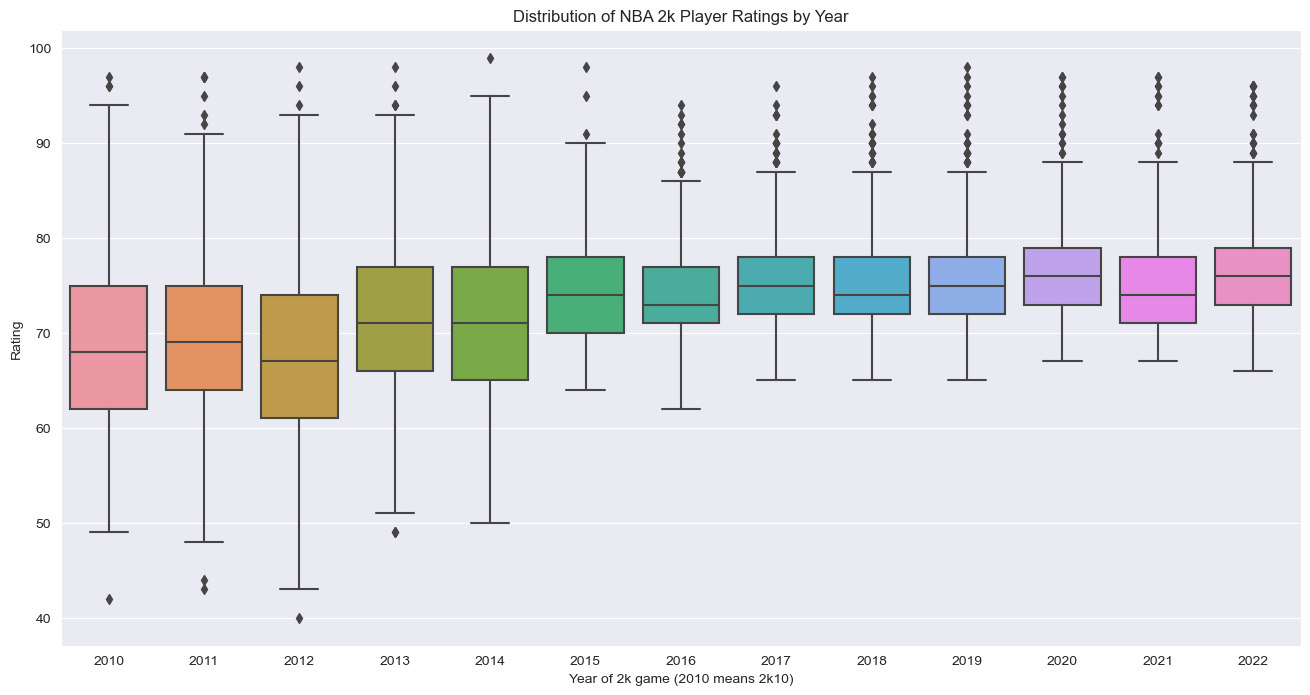

In [7]:
data['2k'] = data['2k'].astype('int')
plt.figure(figsize=(16, 8))
sns.boxplot(x='2k', y='Rating', data=data)
plt.title('Distribution of NBA 2k Player Ratings by Year')
plt.xlabel('Year of 2k game (2010 means 2k10)')
plt.show()

It looks like the rating system changes after 2k14, as there are no longer players with ratings below 60. This makes it look like players with ratings in the mid-80s or higher are outliers for the newer games, however, since the IQR is much smaller due to having no low rated players. Let's see how many players there are with ratings lower than 60.

In [8]:
x = len(data[data['Rating'] < 60])
print('Number of players with a rating less than 60:', x)

y = round(x/len(data)*100, 2)
print('\nPercentage of rows:', str(y)+'%')

Number of players with a rating less than 60: 208

Percentage of rows: 4.3%


There are only 208 observations, or roughly 4.3% of the total number of observations, that have a 'Rating' less than 60. Since more than half of the games in the data do not have players with ratings below 60, I will just drop these rows. 

Another variable that could be of interest is 'MP', or total minutes played. An NBA game lasts a total of 48 minutes, with the starting players usually playing 30+ minutes a game. Since it would be hard to give a player a rating based on very little playing time, let's take a look at 'MP'.

In [9]:
data = data[data['Rating'] >= 60]
print('Summary Statistics for "Minutes Played":')
print(data.MP.describe())

Summary Statistics for "Minutes Played":
count    4632.000000
mean     1516.426598
std       894.330707
min         0.000000
25%       784.000000
50%      1515.500000
75%      2186.250000
max      3985.000000
Name: MP, dtype: float64


75% of the players in the data frame have played 784 minutes or longer, with an average of 1515 minutes or roughly 32 complete games. Let's set a cutoff of 240 minutes, or 5 full games, as it seems unlikely that an accurate prediction for Rating can be made with such little playing time.

In [10]:
print('Number of players with less than 240 minutes played:', len(data[data.MP < 240]))

data = data[data.MP >= 240]

print("\nShape of data after removing players with less than 240 minutes played:")
print(data.shape)

Number of players with less than 240 minutes played: 416

Shape of data after removing players with less than 240 minutes played:
(4216, 25)


After removing players with less than 5 total games played, we are left with 4,216 observations out of the original 4,840, or roughly 87%. Let's rerun the graphs from above to look for any changes.

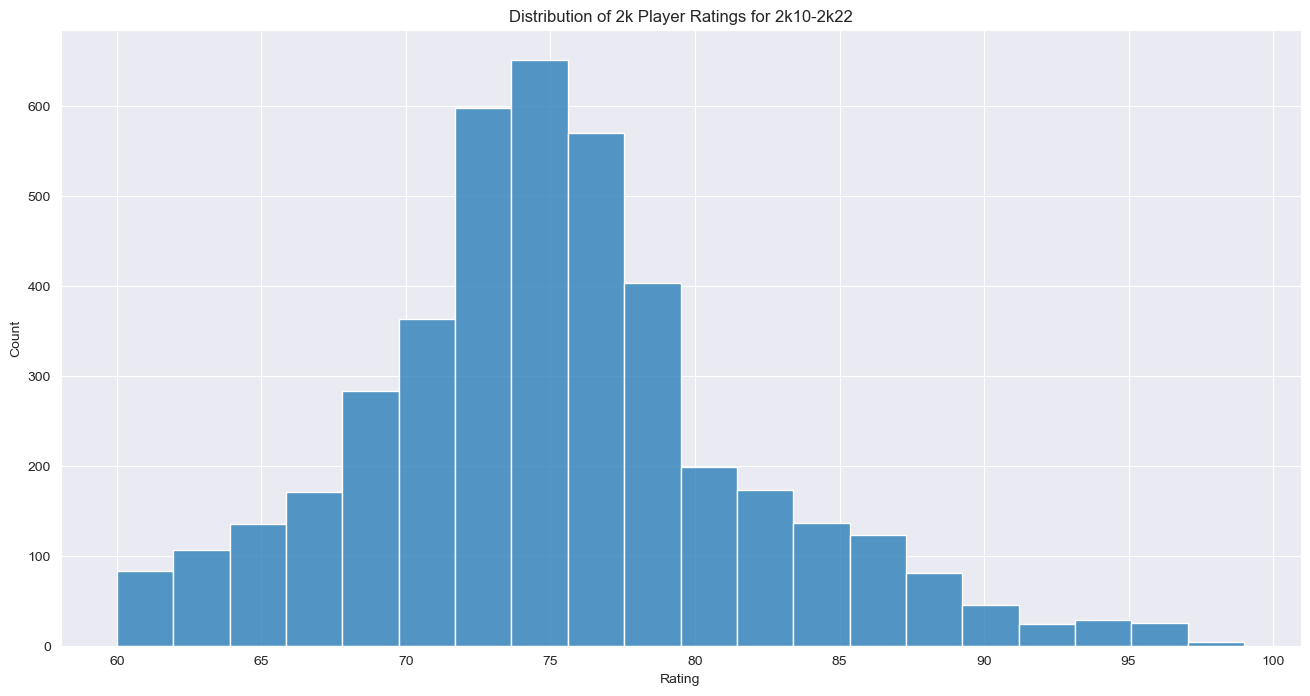

Summary Statistics for "Rating":
count    4216.000000
mean       75.026091
std         6.789342
min        60.000000
25%        71.000000
50%        75.000000
75%        78.000000
max        99.000000
Name: Rating, dtype: float64


In [11]:
plt.figure(figsize=(16, 8))
sns.histplot(x='Rating', data=data, bins=20)
plt.title('Distribution of 2k Player Ratings for 2k10-2k22')
plt.show()
print('Summary Statistics for "Rating":')
print(data.Rating.describe())

After removing the low 'Rating' and low 'MP' players, we get a median of 75, with 50% of the data falling between 71 and 78, which is very similar to before. This new IQR suggests that players with a Rating above 89 are outliers. There is slight right skew now due to the high rated players, however, but it is worth keeping these players in the data to see if other metrics are used for calculating their Ratings.

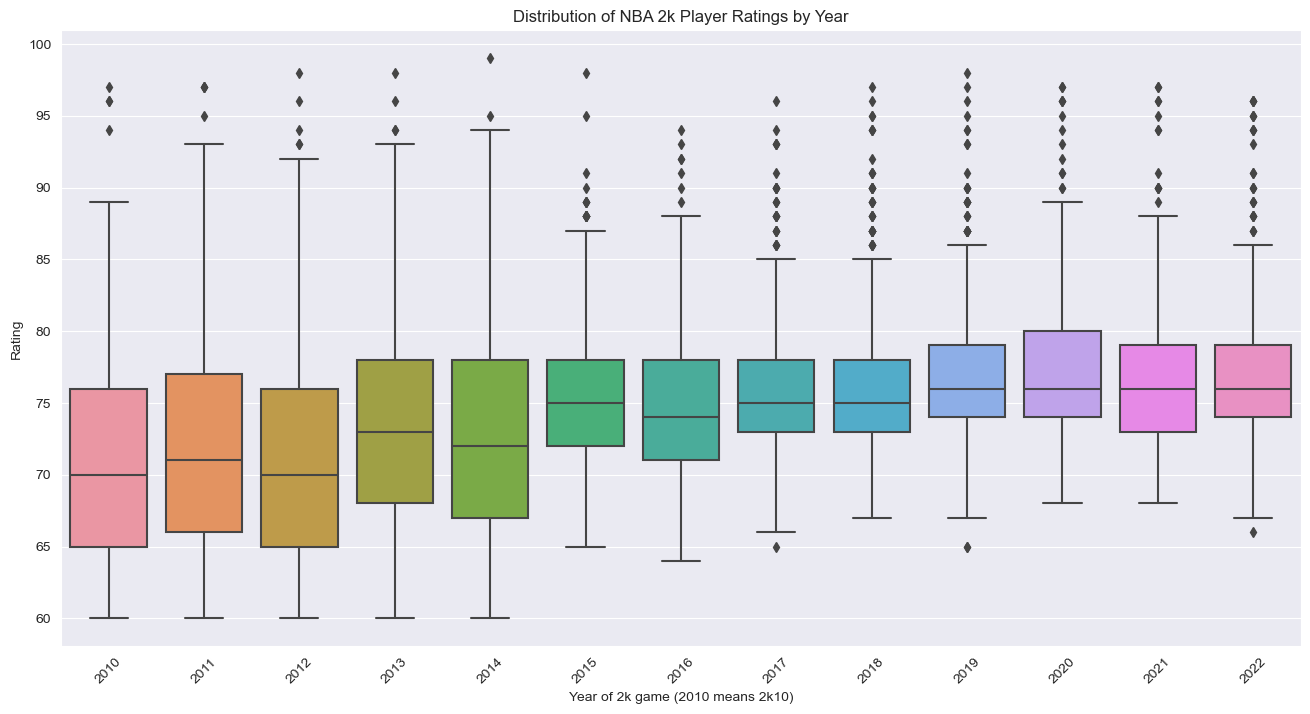

In [12]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='2k', y='Rating', data=data)
plt.title('Distribution of NBA 2k Player Ratings by Year')
plt.xlabel('Year of 2k game (2010 means 2k10)')
plt.xticks(rotation = 45)
plt.show()

Looking at the Boxplots of Rating by Year again, we can see that the median rating has improved from around 70 to over 75 in the past decade. Interestingly, the 3rd quartile (meaning 75% of the data has this 'Rating' or lower), or the top lines of each box, is roughly the same across all the games.

Next, let’s take a look at how 'Rating' varies by position.


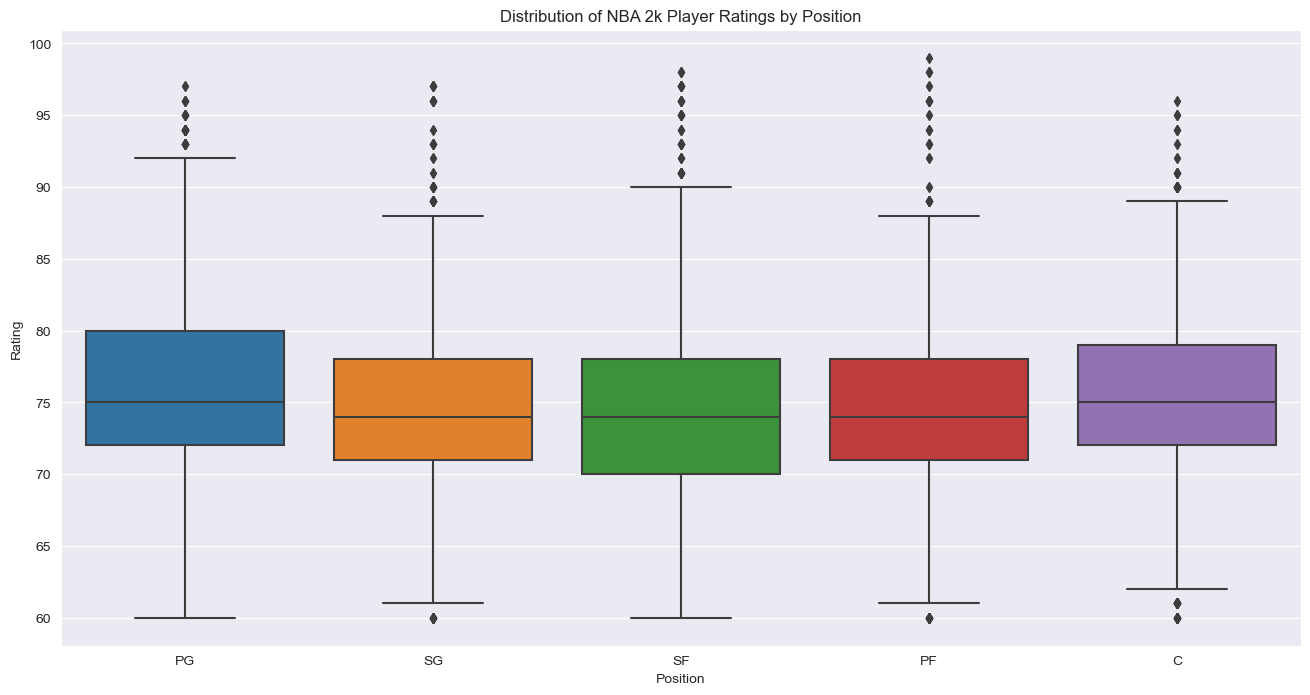

In [13]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='Pos', y='Rating', data=data, order=['PG', 'SG', 'SF', 'PF', 'C'])
plt.title('Distribution of NBA 2k Player Ratings by Position')
plt.xlabel('Position')
plt.show()

It does not look like there is much difference in terms of 'Rating' across the 5 positions. Point Guards, 'PG', look like they have a slightly higher median than the other positions, but roughly 50% of the data across all positions falls between 70 and 80.

Let's take a look at the relationship between 'Rating' and some of the numeric variables.

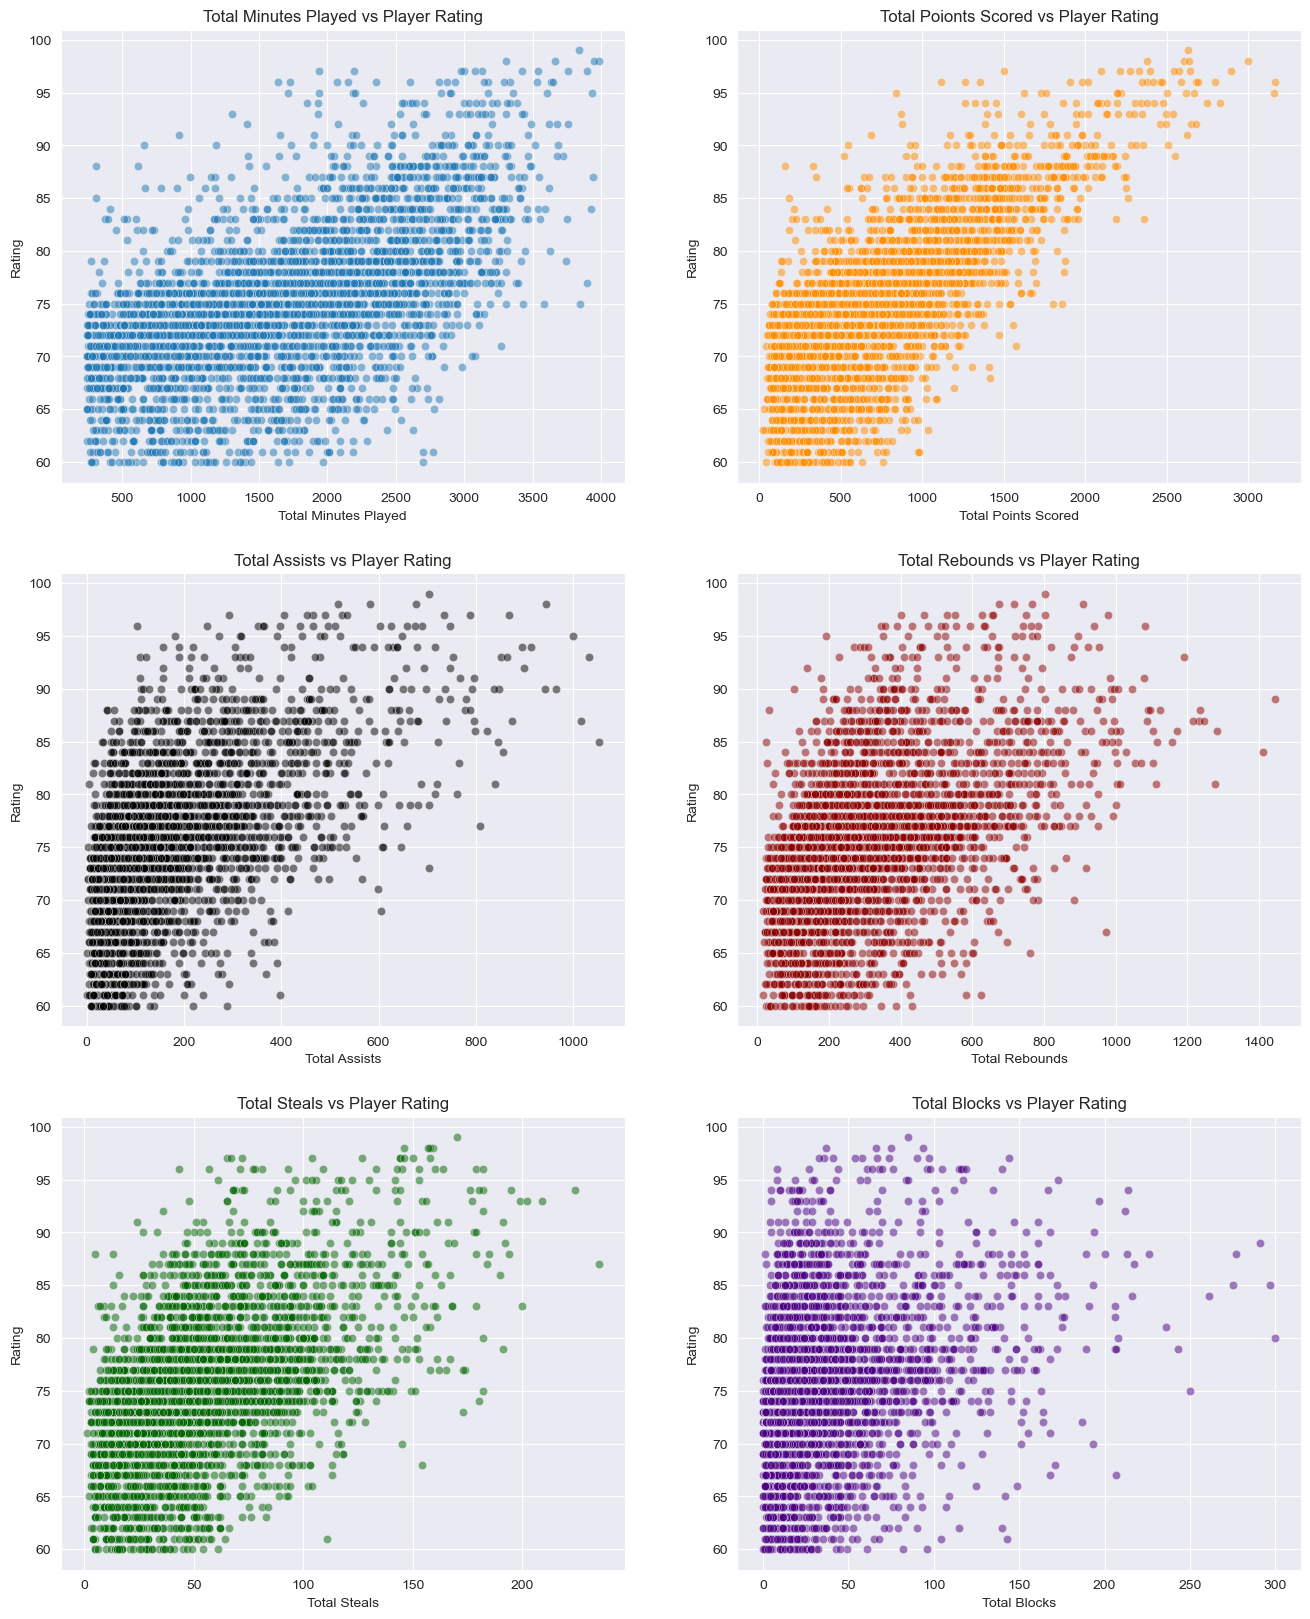

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(16, 20))

sns.scatterplot(ax=axes[0,0], data=data, x='MP', y='Rating', alpha=0.5).set_title('Total Minutes Played vs Player Rating')
axes[0,0].set(xlabel='Total Minutes Played')

sns.scatterplot(ax=axes[0,1], data=data, x='PTS', y='Rating', color='darkorange', 
                alpha=0.5).set_title('Total Poionts Scored vs Player Rating')
axes[0,1].set(xlabel='Total Points Scored')

sns.scatterplot(ax=axes[1,0], data=data, x='AST', y='Rating', color='black',
                alpha=0.5).set_title('Total Assists vs Player Rating')
axes[1,0].set(xlabel='Total Assists')

sns.scatterplot(ax=axes[1,1], data=data, x='TRB', y='Rating', color='darkred',
                alpha=0.5).set_title('Total Rebounds vs Player Rating')
axes[1,1].set(xlabel='Total Rebounds')

sns.scatterplot(ax=axes[2,0], data=data, x='STL', y='Rating', color='darkgreen',
                alpha=0.5).set_title('Total Steals vs Player Rating')
axes[2,0].set(xlabel='Total Steals')

sns.scatterplot(ax=axes[2,1], data=data, x='BLK', y='Rating', color='indigo',
                alpha=0.5).set_title('Total Blocks vs Player Rating')
axes[2,1].set(xlabel='Total Blocks')

plt.show()

Looking at the 'Minutes Played vs Player Rating' plot we can see a somewhat positive relationship between the two variables, but not a very strong relationship. There is quite a large range of 'Minutes Played,' with some players having around 4,000 minutes played in a season, which is over 82 full games, meaning these player's teams likely made a deep run in the playoffs.

Looking at the next plot, 'Total Points Scored vs Player Rating,' we can see a clearer and stronger positive relationship between the two variables. This makes sense, as the players who score the most points are the players that are regarded as the 'best' in the league. Most of the Players appear to have less than 1500 'Total Points', so the relationship between these variables might not be linear.

The third graph shows 'Total Assists vs Player Rating'. Assists is a metric that varies greatly depending on the position of the player, which can kind of be seen in this graph. There is a cluster of players with low assists that likely represents Forwards and Centers, who are usually not primary ball handlers/good passers and therefore have a lower number of assists. We can also see what are likely Guards spread out from the main cluster with a higher number of assists. 

The next graph, 'Total Rebounds vs Player Rating', is very similar to the previous graph, except in this case it is likely the Guards with a lower number of rebounds and the Forwards and Centers with more rebounds. Both this plot and the previous appear to have a weak positive relationship between the variables. 

The last two plots, 'Total Steals vs Player Rating' and 'Total Blocks vs Player Rating' are similar to the two graphs above, as Guards tends to get the most steals while Forwards/Centers get more blocks. Steals appear to have the strongest relationship with Rating out of the last 4 graphs, while Blocks has the weakest.


Now that we have taken a look at the target variable as well as some of the predictor variables and how they relate to each other, I will start building some models to predict 'Rating'. 

### Predicting 'Rating' 

Now I will run a few different models predicting 'Rating' using the other variables. I will start with a basic Linear Regression model that will be used as a 'baseline' to compare against the other models, seeing if more complex models such as Random Forest, ... are computationally worth using. After a final model is selected, I will use it to predict ratings for NBA 2k23 using data from the 2021-2022 NBA season.

#### Linear Regression

To start off, I will create a base Linear Regression model to be used for comparison against other models. A linear regression model assumes that the target variable Y can be calculated from a linear combination of the predictor variables. The equation is $Y = a + b_{1}x_{1} + b_{2}x_{2} + ... + b_{n}x_{n}$, where $a$ is the intercept and $b_{i}$ is the slope for predictor variable $x_{i}$

In [15]:
#This function will be used to calculate and display the R^2 and RMSE of each model
def evaluate_model(model, x_train, y_train, x_test, y_test):
    start = time.time()
    model.fit(x_train, y_train)
    score = np.round(model.score(x_test, y_test), 4)
    preds = model.predict(x_test)
    rmse = np.round(mean_squared_error(y_test, preds, squared=False), 2)
    end = time.time()
    t = round(end-start, 4)
    print('R^2: {}, RMSE: {}\n'.format(score, rmse))
    print(f'Run Time: {t} seconds')
    return score, rmse, t

scores_list = [] # will be used to display model metrics at the end

In [16]:
#Getingt the data in correct format
y = data['Rating'] #target variable

numeric = data.drop(columns=['Player', 'Pos', '2k', 'Rating']) #getting just the numeric variables

cats = data[['Pos']]

cats = pd.get_dummies(cats, drop_first=True)

X = pd.concat([numeric, cats], axis = 1) #putting all the predictor variables back into one dataframe

In [17]:
#Creating our training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=717)

scaler = MinMaxScaler() #Variables are on different scales, need to change that

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [18]:
#Linear Regression Model
lr = LinearRegression()

lr_r2, lr_rmse, lr_t = evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test)

print(f'\nStandard Deviation of "Rating": {round(y.std(), 3)}')

scores_list.append(['Linear Regression', lr_r2, lr_rmse, lr_t])

R^2: 0.69, RMSE: 3.66

Run Time: 0.01 seconds

Standard Deviation of "Rating": 6.789


A linear regression model for predicting 'Rating' results in a $R^{2}$ value of 0.69, meaning that 69% of the variance in 'Rating' can be explained by the predictor variables. We also have a Root Mean Squared Error, or RMSE, of 3.66. RMSE is the standard deviation of the residuals, or predictions errors. A low value for RMSE is good, and when we compare it to the Standard Deviation of 'Rating', we can see that we have a good RMSE from this model. The run time is also extremely fast. Next, let's see if more complicated models will perform better across these 3 metrics. 

#### Random Forest

The Random Forest model is a combination of many different Decision Trees and works on the idea of "collective intelligence." For example, examine a school of fish: they are available to avoid predators more easily when working together than if they were swimming by themselves. Random Forest works in the same way, each Decision Tree does not tell you much information, but when combined with 100s or 1,000s of other Decision Trees, useful insights can be gained. Having many small trees, each with different combinations of variables, provides much better results than a single large tree. I will start off with a Random Forest model with default parameters.

In [19]:
#We can use the same data as above, just need to change the format of y_train to be used for a RF model
y_train = y_train.values.ravel() #changing format of y_train to array 

In [20]:
rf = RandomForestRegressor(random_state=717)

rf_r2, rf_rmse, rf_t= evaluate_model(rf, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Random Forest', rf_r2, rf_rmse, rf_t])

R^2: 0.6886, RMSE: 3.67

Run Time: 2.7726 seconds


The Random Forest model above has performed slightly worse than the Linear Regression model. The $R^{2}$ value decreased by 0.14%, the RMSE is roughly the same, but the run time, although still relatively fast, is longer than the Linear Regression run time. Let's try some Hyperparameter tuning to see if we can get a better Random Forest model.

In [21]:
#Creating a pamater grid to be used with GridSearchCV 
n_estimators = [100, 500, 1000, 1500]     # number of trees
max_depth = [5, 10, 20, None]             # how many variables in each tree
min_samples_leaf = [1, 5, 10]              # minimum number of samples for each node

param_grid = {'n_estimators' : n_estimators,
             'max_depth' : max_depth,
             'min_samples_leaf': min_samples_leaf}

In [22]:
rf2 = RandomForestRegressor(random_state=717)

rf_grid = GridSearchCV(rf2, param_grid, cv=3, verbose=2, n_jobs=-1)

rf_grid.fit(X_train_scaled, y_train)

print(rf_grid.best_params_) 

#started at 12.16 on 11/9, done before 12.23

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 1000}


In [23]:
rf_best = RandomForestRegressor(n_estimators=1000, max_depth=20, min_samples_leaf=1, random_state=717)

rfb_r2, rfb_rmse, rfb_t = evaluate_model(rf_best, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Random Forest w/ HP Tuning', rfb_r2, rfb_rmse, rfb_t])

R^2: 0.6902, RMSE: 3.66

Run Time: 28.4464 seconds


Although this model gives us the best $R^{2}$ value so far, only by 0.02%, the run time is way longer than the previous models at over 27 seconds due to the large number of trees selected. It looks like a Random Forest model, given the selected Hyperparameter values, is not going to outperform the linear regression model. Let's try a Gradient Boosting Model next.

#### Gradient Boosting

Gradient Boosting is similar to Random Forest in that it is a collection of Decision Trees. Random Forest builds all trees separately from each other, while Gradient Boosting builds one tree at a time and makes improvements at each step. In other words, Gradient Boosting combines results as each tree is created, while Random Forest combines the results at the end, after every tree has been created.

In [24]:
gb = GradientBoostingRegressor(random_state=1996)

gb_r2, gb_rmse, gb_t = evaluate_model(gb, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting', gb_r2, gb_rmse, gb_t])

R^2: 0.6881, RMSE: 3.67

Run Time: 0.9902 seconds


A base Gradient Boosting model performs very similarly to the original Linear Regression Model, now lest try hyperparameter tuning on the GB Model.

In [25]:
#Create paramter grid for GB
n_estimators = [100, 200, 500, 1000]   # number of trees
max_depth = [5, 10, 20, None]          # how many variables in each tree
learning_rate = [0.05, 0.1, 0.2]       # how large of an impact each tree has on model 

gb_params = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'learning_rate': learning_rate}

In [26]:
gb2 = GradientBoostingRegressor(random_state=1996)

gb_grid = GridSearchCV(gb2, gb_params, cv=3, verbose=2, n_jobs=-1)

gb_grid.fit(X_train_scaled, y_train)

print(gb_grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


In [27]:
gb_best = GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200, random_state=1996)

gbb_r2, gbb_rmse, gbb_t = evaluate_model(gb_best, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting w/ HP Tuning', gbb_r2, gbb_rmse, gbb_t])

R^2: 0.7029, RMSE: 3.58

Run Time: 3.2747 seconds


In [28]:
scores_df = pd.DataFrame(scores_list, columns=['Model Type', 'R^2', 'RMSE', 'Run Time'])
display(scores_df)

,Model Type,R^2,RMSE,Run Time
0,Linear Regression,0.6900,3.66,0.0100
1,Random Forest,0.6886,3.67,2.7726
2,Random Forest w/ HP Tuning,0.6902,3.66,28.4464
3,Gradient Boosting,0.6881,3.67,0.9902
4,Gradient Boosting w/ HP Tuning,0.7029,3.58,3.2747


The best performing model was the Gradient Boosting model with Hyperparameter tuning. It is worth noting, however, that it only performed slightly better than the original Linear Regression model. The run time for the Gradient Boost model was longer as well but given that it only took roughly 3 seconds to run, it is not really a concern.

Next, let's take a look at the residual plot from our best model to see if prediction accuracy varies by actual 'Rating' at all.

In [29]:
numeric = nolabel.drop(columns=['Player', 'Pos', '2k'])

cats = nolabel[['Pos']]

cats = pd.get_dummies(cats, drop_first=True)

X = pd.concat([numeric, cats], axis = 1)

X_scaled = scaler.transform(X)

In [30]:
preds = gb_best.predict(X_scaled)

preds = np.round(preds).astype('int')

nolabel = nolabel[['Player']]

nolabel['Predicted'] = preds

results = pd.merge(left=nolabel, right=labels, how='inner', on='Player')

results['diff'] = results['Predicted'] - results['Rating']

display(results.sort_values('Predicted', ascending=False).head(10))

,Player,Predicted,Rating,2k,diff
8,Giannis Antetokounmpo,95,97,2023,-2
335,Jayson Tatum,94,93,2023,1
90,Luka Doncic,94,95,2023,-1
81,Stephen Curry,94,96,2023,-2
181,Nikola Jokic,93,96,2023,-3
101,Joel Embiid,93,96,2023,-3
172,LeBron James,93,96,2023,-3
97,Kevin Durant,92,96,2023,-4
385,Trae Young,91,90,2023,1
58,Jimmy Butler,90,93,2023,-3


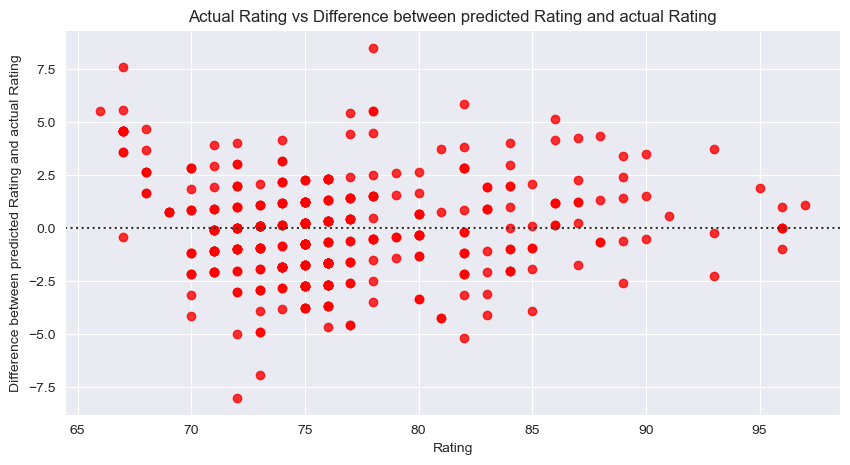

In [31]:
plt.figure(figsize=(10, 5))
sns.residplot(x='Rating', y='diff', data=results, color='red')#lowess=True, line_kws=dict(color="orange"))
#sns.scatterplot(x='Rating', y='diff', data=results, color='darkblue').axhline(0, color='red', alpha=0.5)
plt.title('Actual Rating vs Difference between predicted Rating and actual Rating')
plt.ylabel("Difference between predicted Rating and actual Rating")
plt.show()

The plot above is a Residual plot, showing the player Rating for NBA 2k23 on the X-axis, and the difference between the predicted rating and the actual rating on the Y-axis. A negative value on the y-axis indicates that the model predicted a lower rating than what the actual rating is. It looks like the model over predicted the rating for most players under 70, however it looks like there are not that many players with that low of a rating. Besides those and a few outliers that are far away from 0, the residual plot looks good in that there is no discernable pattern. 

### Conclusions and Future Work

After running a few different models, it appears unlikely that the predictors used are the only variables considered by 2k Games when creating player ratings. The best model only achieved an $R^{2}$ of roughly 70%, meaning that 70% of the variation in 'Rating' can be explained by the used predictor variables. The residual plot looks quite good, besides for a few outliers and the model overpredicting the rating for players with 'Ratings' below 70. Interestingly, I expected the model to underpredict the ratings for high rated players, but this was not the case. 

Given that 2k must take other statistics/information into account when creating player Ratings, something I could do is include various awards from each season. Including things like All Star, All NBA First team, Second team, Third team, all defensive team and whether or not the team made the playoffs could provide better results. Other individual awards, such as scoring leader, MVP, defensive MVP would not be useful to include, as only 1 player wins each of these awards every season, so it would make the data sparser. Another thing that could be done to improve performance would be to take a deeper look at Minutes Played, given how the model tended to overpredict the rating of lower rated players. It is likely that the lowest rated players are playing less minutes, so maybe a higher cutoff would be better. I could possibly also not use data from before 2k15 as it looks like the rating system changed from this game onward.


I will continue to update the data for each season. The NBA is considering changing things up with the structure of the season, by talking about including a mid-season tournament. More data could help improve results. The other things mentioned above, such as including awards, might be difficult/time consuming to implement as it would require combining data from multiple sources.
